# Time Series Exploratory Data Analysis

The data for the motor vehicle collisions on public roads in Canada can be found in [open.canada.ca](https://open.canada.ca/data/en/dataset/1eb9eba7-71d1-4b30-9fb1-30cbdab7e63a).   We have extracted a time series data for total monthly fatality from 1999 to 2017.

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams

# Set font scale and style
plt.rcParams.update({'font.size': 18})

# Stat models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# Instantiate the class
fxn = TimeSeriesForecasting()

## Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 9)


,fatality_rate,med_fatal,med_injury,med_no_injury,not-head-on,head-on,year,month,summer_ind
date,,,,,,,,,
1999-01-01,0.013067,85.0,99.0,48.0,108.0,124.0,1999,1,0
1999-02-01,0.017570,101.0,108.0,40.0,93.0,156.0,1999,2,0
1999-03-01,0.021727,105.0,170.0,48.0,96.0,227.0,1999,3,0
1999-04-01,0.013606,99.0,84.0,32.0,44.0,171.0,1999,4,0
1999-05-01,0.018343,150.0,165.0,53.0,79.0,289.0,1999,5,0


## Missing values
There are no missing values in the time series data

In [5]:
ts.isnull().sum() 

fatality_rate    0
med_fatal        0
med_injury       0
med_no_injury    0
not-head-on      0
head-on          0
year             0
month            0
summer_ind       0
dtype: int64

## Descriptive statistics

In [6]:
ts.describe()

,fatality_rate,med_fatal,med_injury,med_no_injury,not-head-on,head-on,year,month,summer_ind
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,0.015801,105.298246,109.096491,54.504386,74.166667,194.732456,2008.000000,6.500000,0.250000
std,0.003069,32.343266,42.560446,18.603561,28.551959,70.621242,5.489277,3.459648,0.433965
min,0.006917,22.000000,32.000000,17.000000,16.000000,48.000000,1999.000000,1.000000,0.000000
25%,0.013600,83.000000,76.750000,40.000000,53.000000,142.750000,2003.000000,3.750000,0.000000
50%,0.015679,102.500000,103.000000,54.000000,70.000000,182.000000,2008.000000,6.500000,0.000000
75%,0.017681,129.250000,132.250000,67.000000,89.000000,238.250000,2013.000000,9.250000,0.250000
max,0.026572,187.000000,276.000000,112.000000,184.000000,476.000000,2017.000000,12.000000,1.000000


## Correlations of predictors

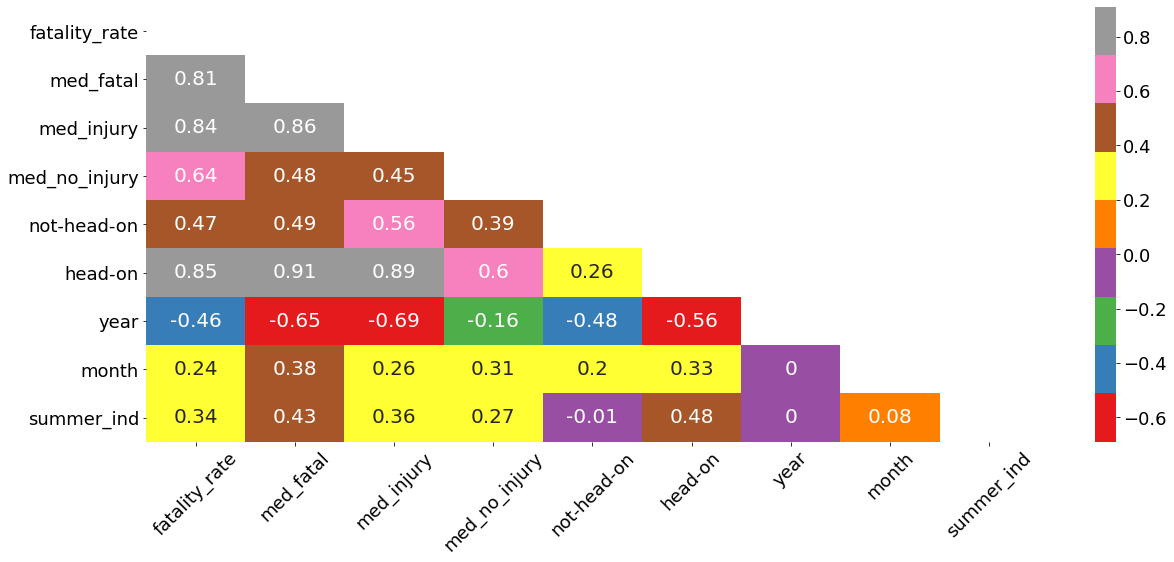

In [7]:
fig, ax = plt.subplots(figsize=(20,8))
corr_mtx = ts.corr()

# Plot
mask = np.zeros_like(corr_mtx, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(round(corr_mtx, 2), annot=True, annot_kws={"size": 20}, mask = mask,
            cmap =plt.get_cmap("Set1"),ax = ax)
plt.xticks(rotation = 45)
plt.show()

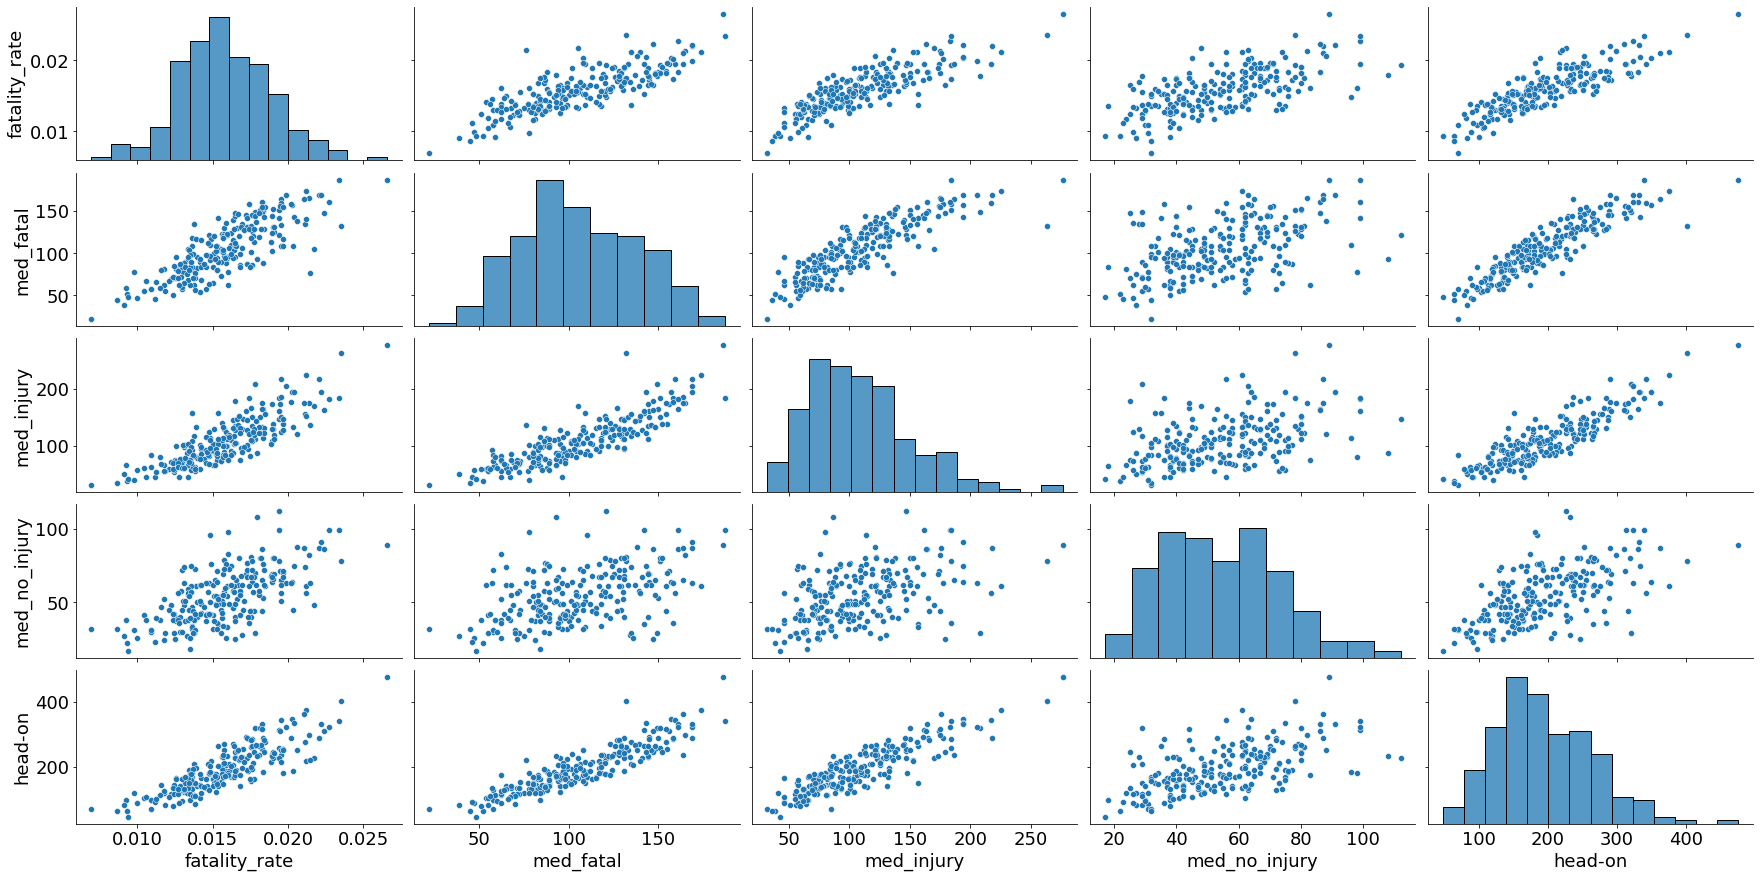

In [14]:
cols = ['fatality_rate', 'med_fatal', 'med_injury', 'med_no_injury', 'head-on']
sns.pairplot(ts[cols],height=2.5, aspect=2)
plt.show()

## Time series plot

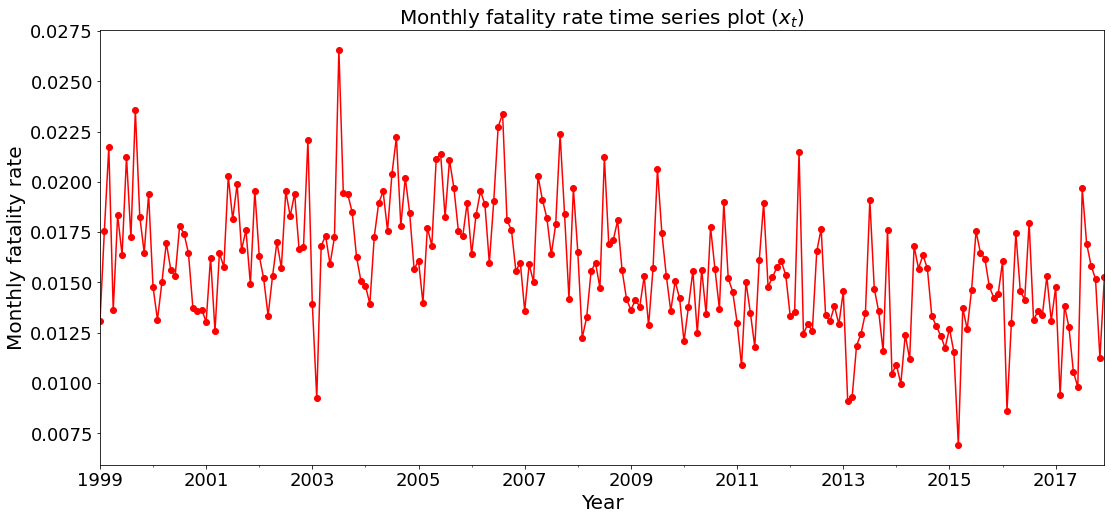

In [8]:
fxn.plot_timeseries(ts.fatality_rate, marker= 'o', color = 'r', 
                    title = 'Monthly fatality rate time series plot ($x_t$)')

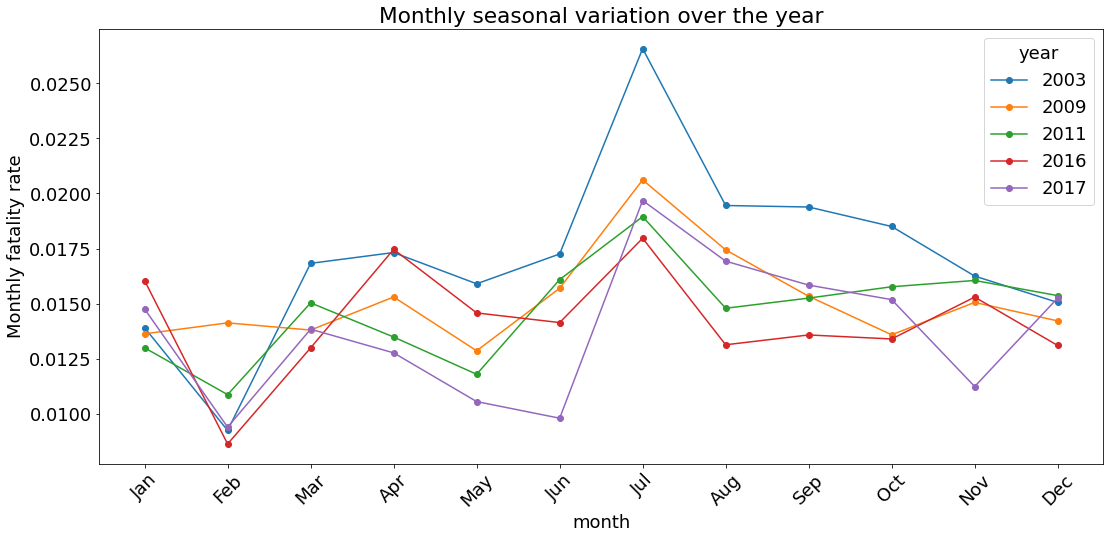

In [9]:
df = ts.copy()[['year', 'month', 'fatality_rate']]
pvt = df.pivot_table('fatality_rate', index='month', columns= 'year')
pvt[[2003,2009,2011,2016, 2017]].plot(marker = 'o', figsize = (18,8))
labels = ['Jan', 'Feb', "Mar", 'Apr', 'May', 'Jun', 'Jul', "Aug", 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(1,13,1), labels, rotation = 45)
plt.ylabel("Monthly fatality rate")
plt.title('Monthly seasonal variation over the year')
plt.show()

## Stationarity Test (Augmented Dickey-Fuller Test)

A time series is stationary if its statistical properties (such as mean and standard deviation) are constant over time (i.e. the time series is in statistical equilibrium). Therefore, time series with trend and seasonality are not stationary. The importance of this is that a stationary series is likely to repeat its behaviour in the future. In other words, the time series will have no predictable patterns in the future.

The current time series is non-stationary due to seasonality. To formally test for stationarity, we use the  Augmented Dickey-Fuller (ADF) test to check for the presence of a unit root in the time series. The null hypothesis is that the time series is non-stationary, that is it has a unit root. We can reject the null hypothesis if the test statistic is less than the critical value or the p-value is less than 0.05.

The results below show that the time series is non-stationary because the null hypothesis cannot be rejected as the test statistic is greater than the critical values and the p-value is greater than 0.05.

The stationarity test of a time series can also be investigated by plotting the autocorrelation function (ACF). For a nonstationary time series the ACF will not decay quickly, whereas for a stationary time series the ACF  decays exponentially to 0 as lag increases.  The plot of ACF above shows that the time series is non-stationary.

Test statistic: -1.4596622176948828
p-value: 0.5533632091458887
Critial Values (1%): -3.460992
Critial Values (5%): -2.875016
Critial Values (10%): -2.573952


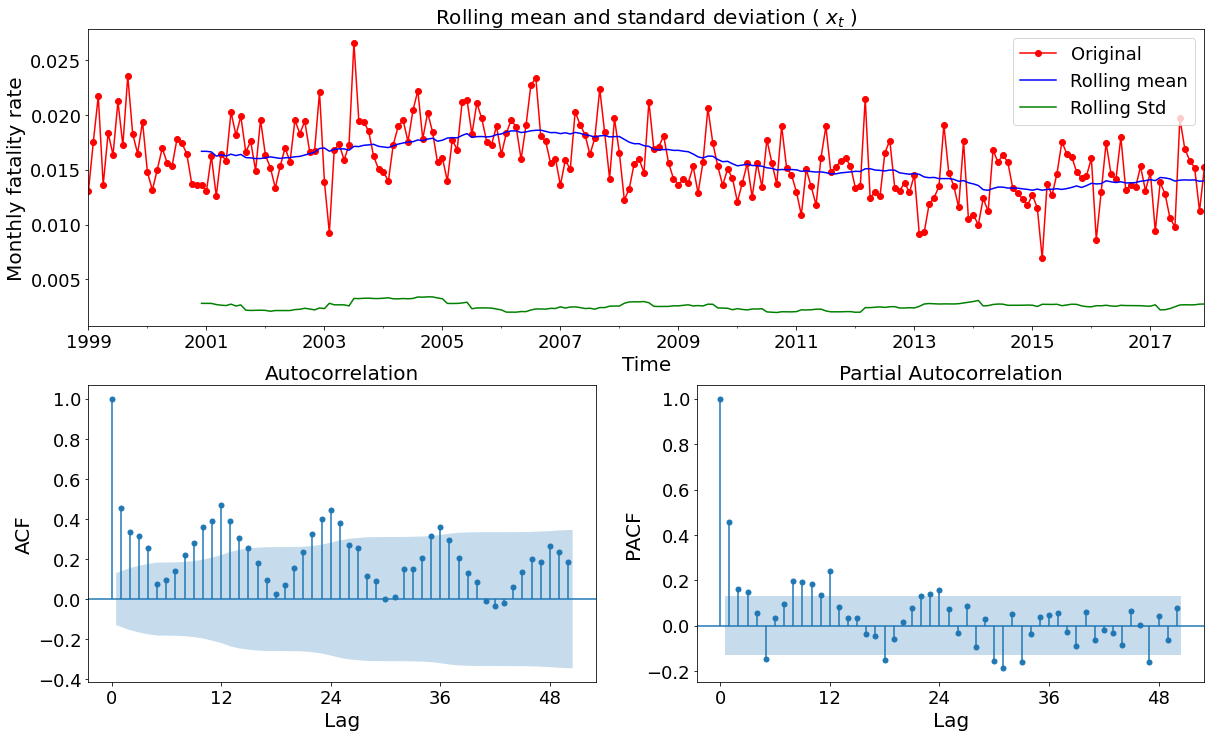

In [19]:
plt.figure(figsize=(20, 12))
fxn.plot_ts(ts.fatality_rate, title = 'Rolling mean and standard deviation ( $x_t$ )', nlags = 50)

## Log transformation

In [20]:
ts['_log'] = np.log(ts['fatality_rate'])

Test statistic: -1.3745759232902537
p-value: 0.594402242171103
Critial Values (1%): -3.460992
Critial Values (5%): -2.875016
Critial Values (10%): -2.573952


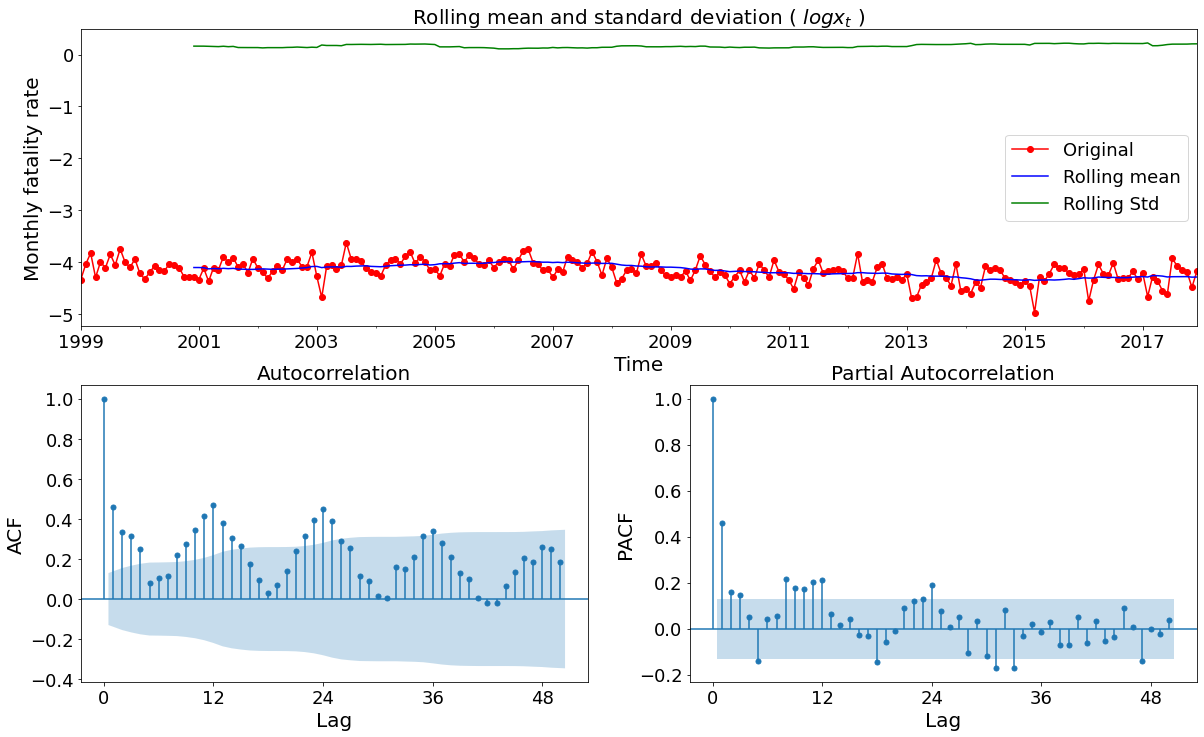

In [21]:
plt.figure(figsize=(20, 12))
fxn.plot_ts(ts._log,  title = 'Rolling mean and standard deviation ( $log x_t$ )',nlags = 50)

## Seasonality
We have strong monthly seasonality in the data

<Figure size 432x288 with 0 Axes>

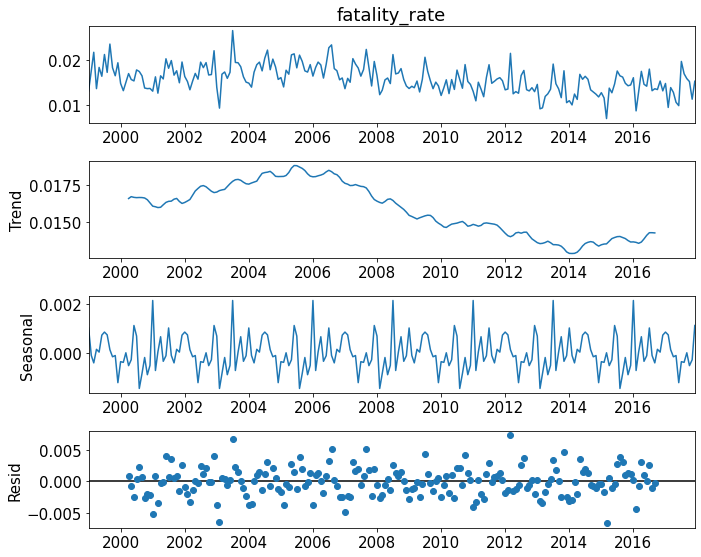

In [22]:
plt.figure()
rcParams['figure.figsize'] = 10,8
plt.rcParams.update({'font.size':15})

decomposition = seasonal_decompose(ts.fatality_rate, model='additive', period = 30)
decomposition.plot()
plt.show()

## Regular differencing
Differencing is one of the common methods for transforming a non-stationary time series to a  (weakly) stationary one. The first difference of a nonstationary time series  is a new time series which may be stationary. First, we take the log transformation of the time series and apply the first difference on the log transformed series.

We see that the test statistic is signicantly less than 1$\%$ critical value  and the p-value is less than 0.05. Therefore, the time series is stationary with 99$\%$ confidence. The ACF and  PACF of the difference log transformed time series evidently decay quickly which corroborate the fact that the log transformed time series  is weakly stationary. In addition, the ACF has significant spikes at lags 12, 24, 36, indicating seasonality in the time series data

In [23]:
# Apply first difference
ts['_log_diff'] = ts['_log'] - ts['_log'].shift(1) 

Test statistic: -10.636856543581954
p-value: 5.046315085692475e-19
Critial Values (1%): -3.460992
Critial Values (5%): -2.875016
Critial Values (10%): -2.573952


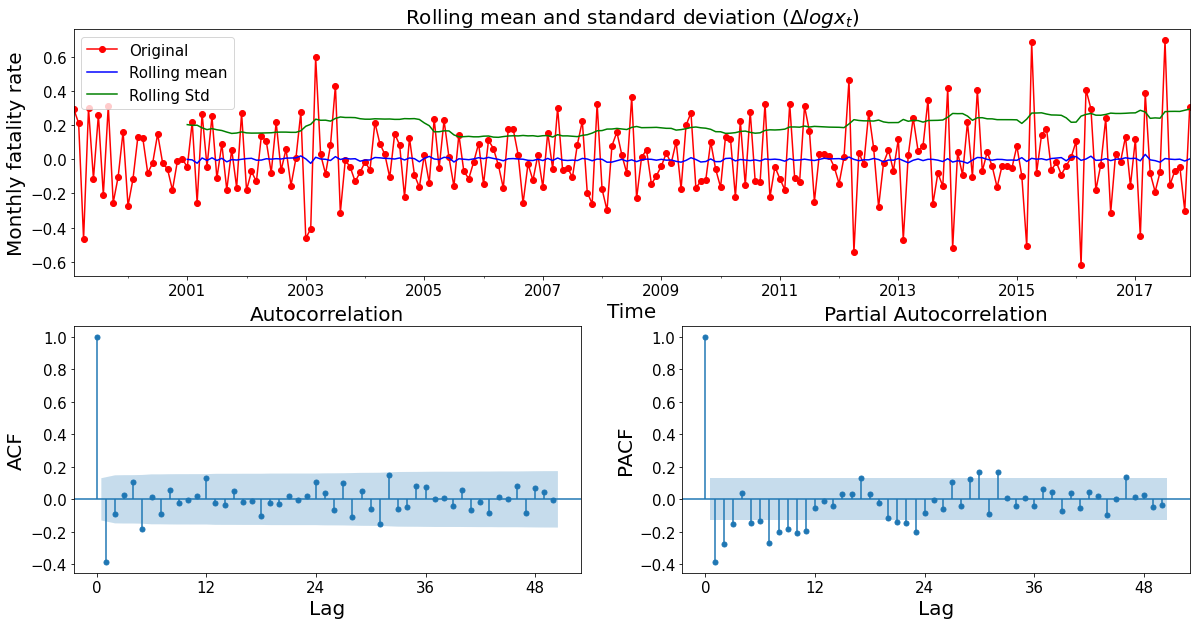

In [24]:
plt.figure(figsize=(20, 10))
fxn.plot_ts(ts._log_diff.dropna(),  title = 'Rolling mean and standard deviation ($\Delta log x_t$)', nlags = 50)

## Seasonal differencing
The analysis above suggests that we need a seasonal differencing of the time series.   Below we perform a 12-month seasonal differencing of the log transformed time series.

From the ACF and partial ACF plots, we can make the following observations:

1. The ACF is negative and statistically significant at lag 12. In other words, the serial correlation is different from zero at the seasonal lag.

2. The partial ACFs are negative and statistically significant at lags 12, 24, 36. 

In [25]:
ts['_log_sdiff'] = ts['_log'] - ts['_log'].shift(12)

Test statistic: -6.34119435595554
p-value: 2.7520749106486155e-08
Critial Values (1%): -3.462818
Critial Values (5%): -2.875815
Critial Values (10%): -2.574379


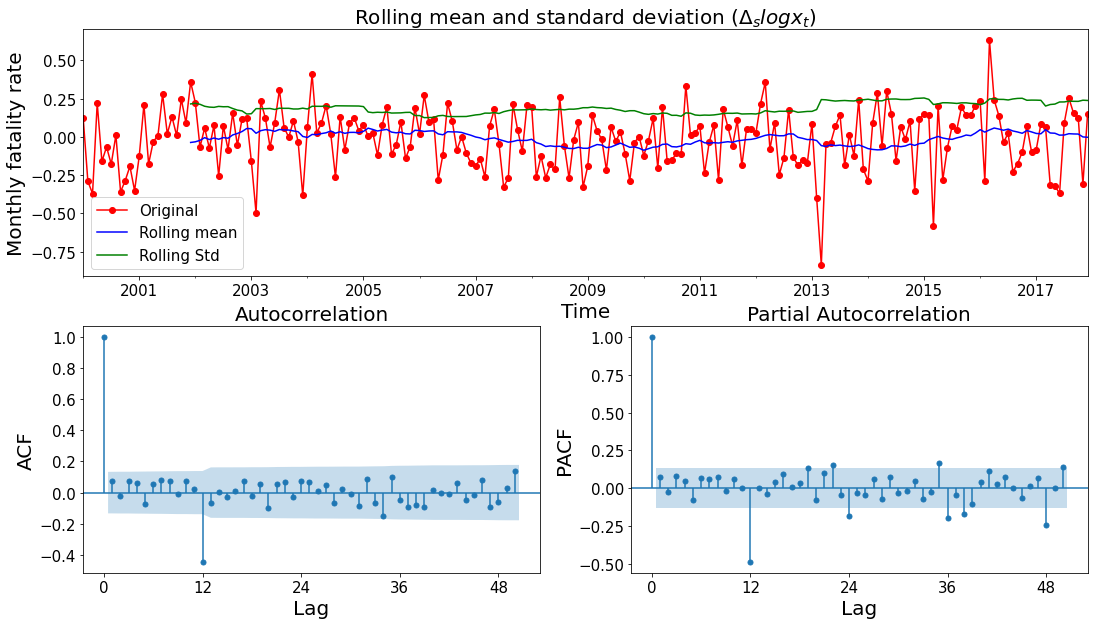

In [26]:
plt.figure(figsize=(18, 10))

fxn.plot_ts(ts._log_sdiff.dropna(), title = 'Rolling mean and standard deviation ($\Delta_s log x_t$)', nlags = 50)

## Combined regular and seasonal diffferencing

We now compute the combined regular and seasonal diffferencing of the time series and its ACF and partial ACF.

From the plots below, we can identify the orders of the regular and seasonal moving averages. For instance, we can see that the autocorrelation appears to be insignifcant at lags 24 and 36, whereas it has a negative spike at lag 12 after which the seasonal autocorrelation cuts off. This would suggest that the data could be modeled with a moving average model applied to the 12-month period. 

To identify the moving average of the regular time series, we look at patterns between successive months. We see that there is a signifcant autocorrelation a lag 1, after which the autocorrelation seems to cut off. This would indicate a first order moving average for the regular time series.

In [27]:
ts['_log_sddiff'] = ts['_log_sdiff'] - ts['_log_sdiff'].shift(1)

Test statistic: -6.275878165062634
p-value: 3.901879765047643e-08
Critial Values (1%): -3.463476
Critial Values (5%): -2.876102
Critial Values (10%): -2.574532


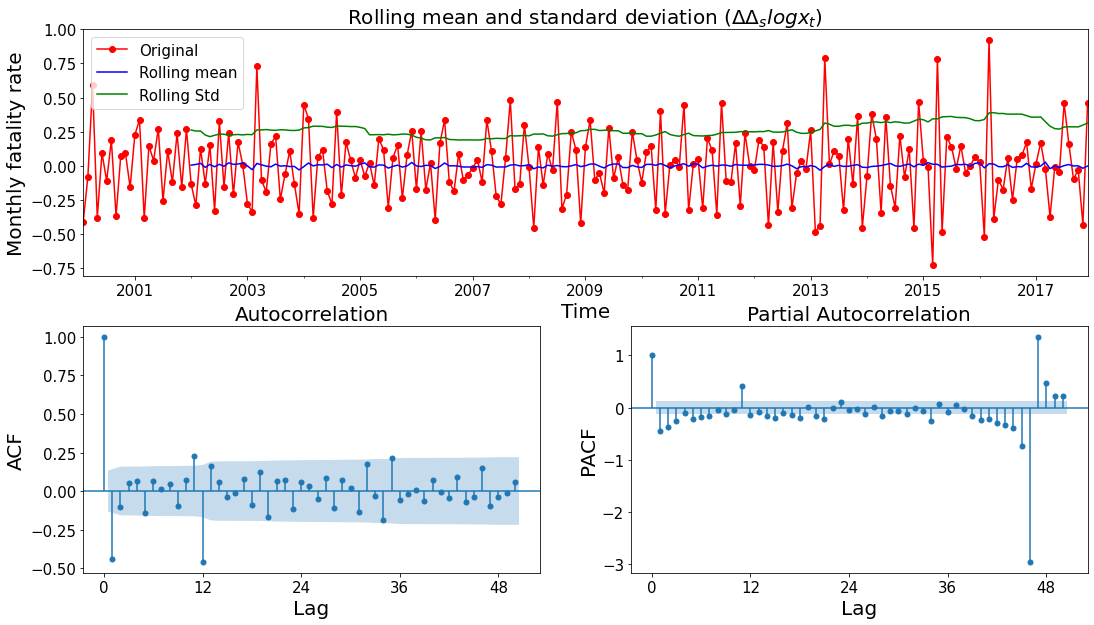

In [28]:
plt.figure(figsize=(18, 10))

fxn.plot_ts(ts._log_sddiff.dropna(), 
        title = 'Rolling mean and standard deviation ($\Delta \Delta_s log x_t$)', nlags = 50)